# 1. Análisis exploratorio de sismos

**Objetivo:** Exploración del dataset

Esta base de de datos es una colección de más de 23,000 sismos en USA. Contiene datos desde 1638 a 1985. La base de datos incluye información correspondiente a las coordenadas del epicentro, magnitudes, profundidad focal, nombres y coordenadas de ciudades reportadas, intensidades reportadas y la distancia de la ciudad al epicentro.


https://www.kaggle.com/srijya/us-earthquake-intensity-database

**Información de las características**
* 0 Year Mo Da Hr Mn Sec
* 1 UTC Conv
* 2 U/G Unpublished or grouped intensity
* 3 EQ Lat 
* 4 EQ Long
* 5 Magnitude
* 6 Depth (km)
* 7 Epi Dis Distancia epicentral
* 8 City Lat
* 9 City Long
* 10 MMI
* 11 State Code
* 12 City Name
* 13 Data Source

**Número de instancias:** 157015

**Número de atributos:** 20



# 2. Acceso a Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# 3. Importando librerías

In [ ]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
import plotly.express as px
import plotly.io as pio

# 4. Lectura del archivo de datos

In [ ]:
path = r'/content/drive/Shareddrives/Data Science para Geociencias/7. Modelos de ensamble/7.1 Boosting'
name = 'eqint_tsqp.xlsx'

In [ ]:
sis_path = os.path.join(path,name)
sismosdf = pd.read_excel(sis_path)
sismosdf.head()

,YEAR,MONTH,DAY,HOUR,MINUTE,SECOND,LOCAL_TO_UTC,UNPUB_OR_GROUPED_INT,LATITUDE,LONGITUDE,MAGNITUDE,EQ_DEPTH,EPIDIST,CITY_LAT,CITY_LON,MMI,STATE,CITY,SOURCE,COUNTRY
0,1852,11.0,27.0,NaN,NaN,NaN,8.0,NaN,34.5,-119.0,NaN,NaN,0.0,34.50,-119.00,7.0,CA,LOCKWOOD VALLEY,H,USA
1,1852,11.0,27.0,NaN,NaN,NaN,8.0,NaN,34.5,-119.0,NaN,NaN,258.0,33.02,-116.84,6.0,CA,SAN DIEGO,H,USA
2,1852,11.0,27.0,NaN,NaN,NaN,8.0,NaN,34.5,-119.0,NaN,NaN,159.0,35.35,-120.41,6.0,CA,SAN LUIS OBISPO,H,USA
3,1852,11.0,27.0,NaN,NaN,NaN,8.0,NaN,34.5,-119.0,NaN,NaN,NaN,NaN,NaN,6.0,CA,COLORADO RIVER,H,USA
4,1860,11.0,12.0,NaN,NaN,NaN,8.0,NaN,41.0,-124.0,NaN,NaN,32.0,40.76,-124.22,8.0,CA,HUMBOLDT BAY,H,USA


In [ ]:
sismosdf.shape

(157015, 20)

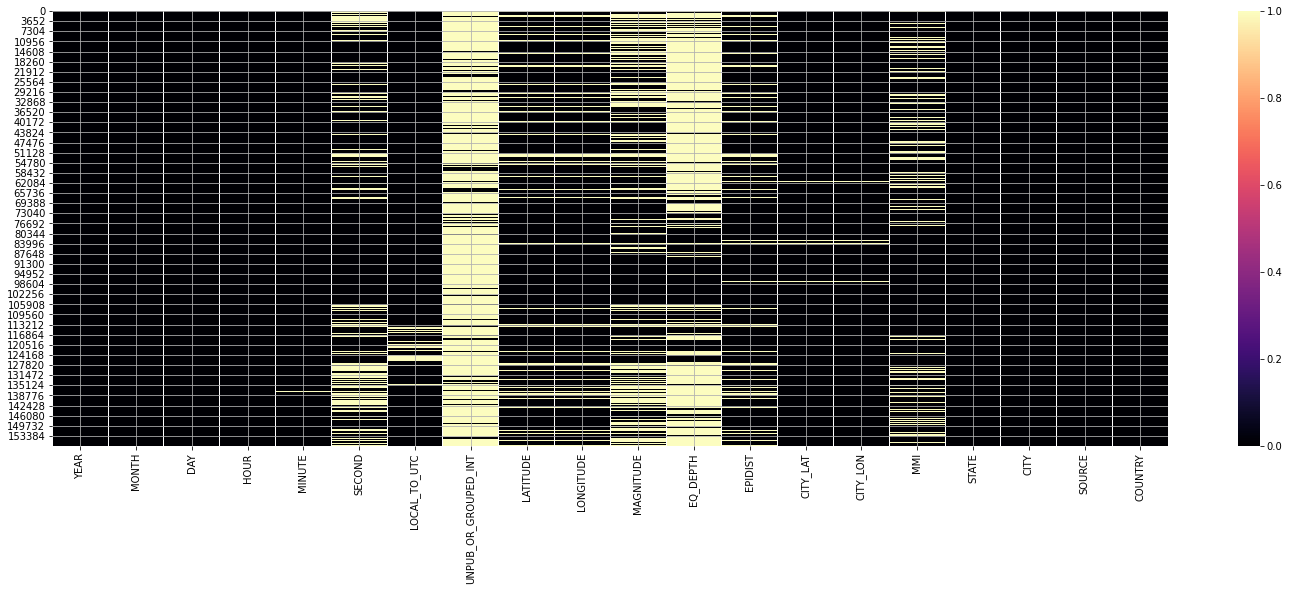

In [ ]:
fig, ax = plt.subplots(figsize=(25,8))
sns.heatmap(sismosdf.isnull(), ax=ax, cmap="magma")
plt.grid()
plt.show()

# 5. Limpieza de datos

In [ ]:
sismosdf.drop(['UNPUB_OR_GROUPED_INT','LATITUDE','LONGITUDE','EQ_DEPTH', 'LOCAL_TO_UTC'], axis=1, inplace=True)

In [ ]:
sismosdf['SECOND'].fillna(0, inplace=True)
sismosdf['MINUTE'].fillna(sismosdf['MINUTE'].mode(), inplace=True)
sismosdf['HOUR'].fillna(sismosdf['HOUR'].mode(), inplace=True)
sismosdf['EPIDIST'].fillna(sismosdf['EPIDIST'].mean(), inplace=True)

In [ ]:
sismosdf = sismosdf[sismosdf.MMI.notnull()]
sismosdf = sismosdf[sismosdf.YEAR.notnull()]
sismosdf = sismosdf[sismosdf.MONTH.notnull()]
sismosdf = sismosdf[sismosdf.DAY.notnull()]
sismosdf = sismosdf[sismosdf.CITY_LAT.notnull()]
sismosdf = sismosdf[sismosdf.CITY_LON.notnull()]
sismosdf = sismosdf[sismosdf.MAGNITUDE.notnull()]

In [ ]:
fig, ax = plt.subplots(figsize=(25,8))
sns.heatmap(sismosdf.isnull(), ax=ax, cmap="magma")
plt.grid()
plt.show()

In [ ]:
sismosdf.shape

(89617, 15)

# 6. Exploración de los datos

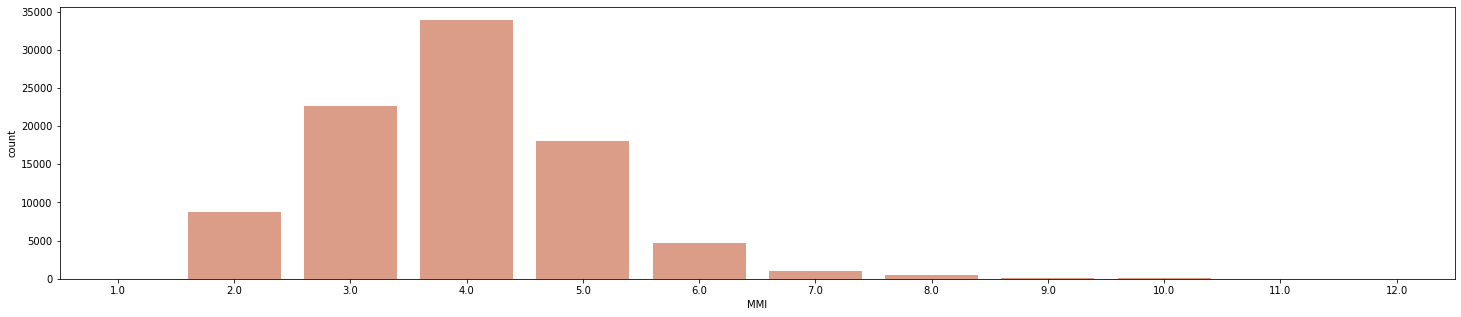

In [ ]:
fig, ax = plt.subplots(figsize=(25,5))
sns.countplot(ax=ax, x=sismosdf['MMI'], color='darksalmon')
plt.show()

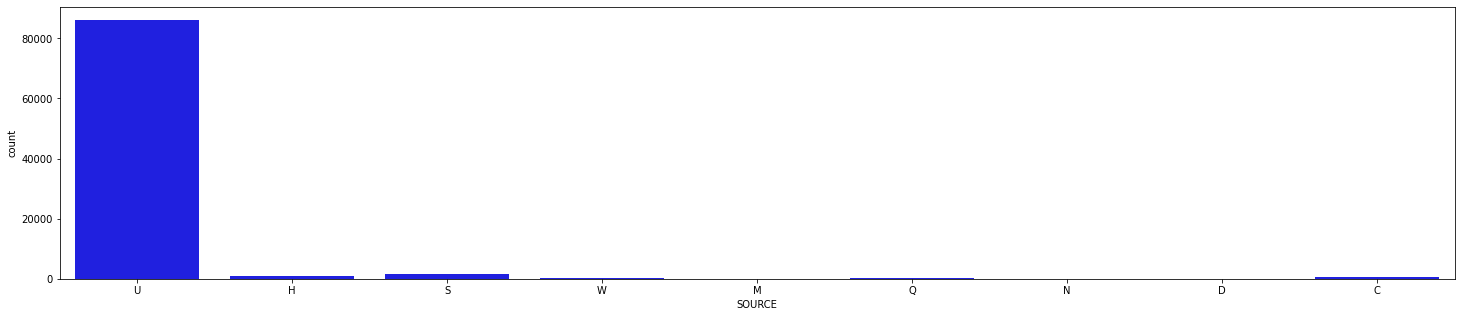

In [ ]:
fig, ax = plt.subplots(figsize=(25,5))
sns.countplot(ax=ax, x=sismosdf['SOURCE'], color='blue')
plt.show()

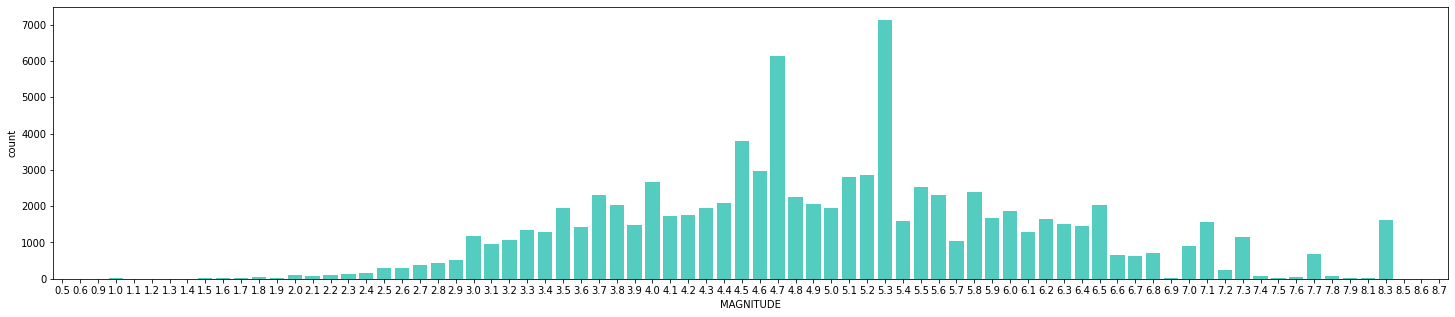

In [ ]:
fig, ax = plt.subplots(figsize=(25,5))
sns.countplot(ax=ax, x=sismosdf['MAGNITUDE'], color='turquoise')
plt.show()

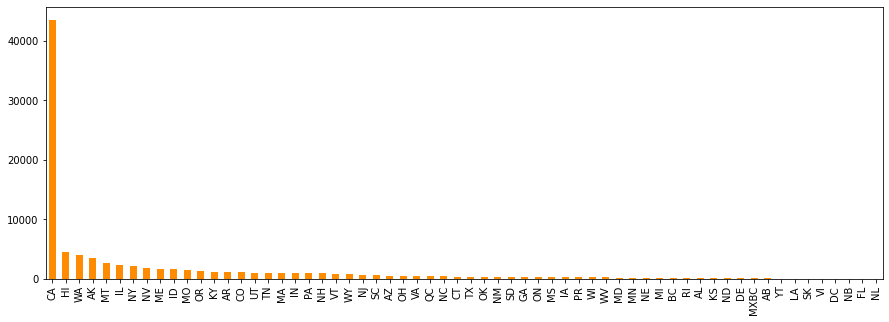

In [ ]:
sismosdf['STATE'].value_counts().plot(kind='bar', figsize=(15,5), grid=False, color='darkorange')

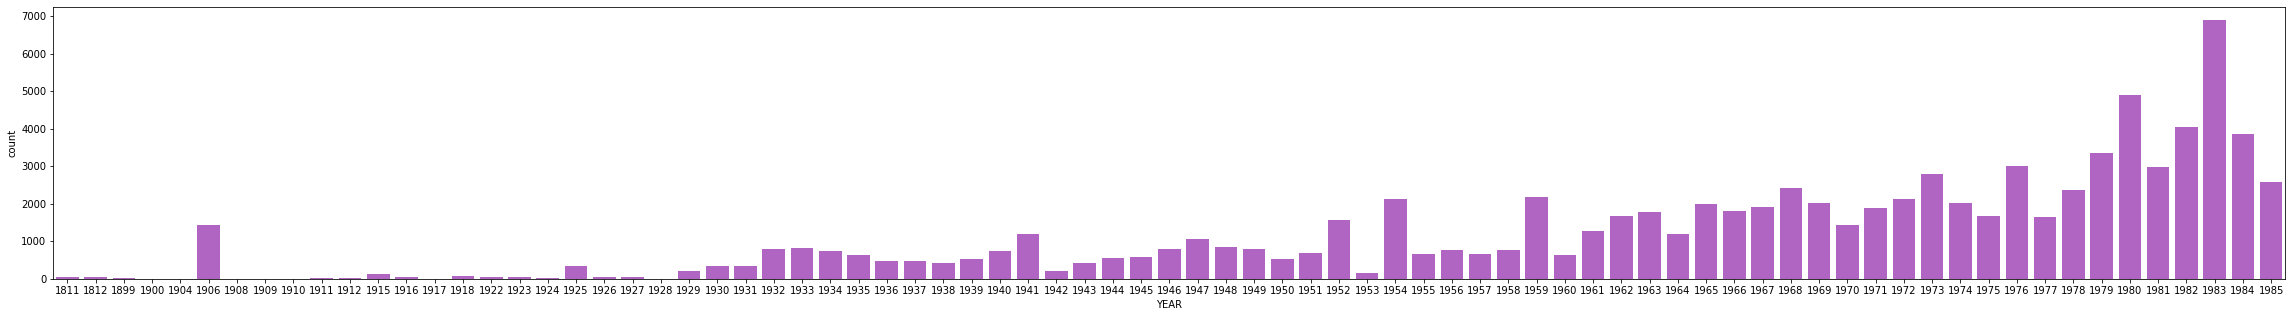

In [ ]:
fig, ax = plt.subplots(figsize=(40,5))
sns.countplot(ax=ax, x=sismosdf['YEAR'], color='mediumorchid')
plt.show()

In [ ]:
fig = go.Figure(data=go.Scattergeo(
        lon = sismosdf['CITY_LON'],
        lat = sismosdf['CITY_LAT'],
        text = sismosdf['MMI'],
        marker = dict(
        color = sismosdf['MMI'],
        colorscale = 'Rainbow',
        reversescale = True,
        opacity = 0.7,
        size = 5,
        colorbar = dict(
            titleside = "right",
            outlinecolor = "rgba(68, 68, 68, 0)",
            ticks = "outside",
            showticksuffix = "last",
            dtick = 1
        )
    )
        ))
fig.update_traces(marker=dict(size=15),
                  selector=dict(mode='markers'))
fig.update_layout(
    margin=dict(l=0, r=0, b=0, t=25),
    title = 'Intensidad de sismos',
    geo_scope='usa',
    )
fig.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
sismosdf = sismosdf.set_index(['YEAR', 'MONTH'])
index_list = sismosdf.index.levels[0].tolist()
frames=[{
        'name': 'frame_{}'.format(i),

        'data': [{
            'type': 'scattermapbox',
            'lat': sismosdf.xs(i)['CITY_LAT'],
            'lon': sismosdf.xs(i)['CITY_LON'],
            'marker': go.scattermapbox.Marker(
                size=(sismosdf.xs(i)['MMI']-sismosdf.xs(i)['MMI'].mean()+3.5)**2 +sismosdf.xs(i)['MMI'],
                color=sismosdf.xs(i)['MMI'],
                showscale=True,
                colorscale='Jet',
                colorbar={'title': 'Intensidad', 'titleside': 'top', 'thickness': 4, 'ticksuffix': ' MMI'}
                ),
        'customdata': np.stack((
            sismosdf.xs(i)['MMI'],
            sismosdf.xs(i)['MAGNITUDE'],
            pd.Series(sismosdf.xs(i).index)),
                axis=-1
                ),
        'hovertemplate': "<extra></extra><em> Intensidad  %{customdata[0]}<br>Magnitud  %{customdata[1]}",
        }],
    } for i in index_list]

sliders = [{
            'transition':{'duration': 0},
            'x':0.08,
            'len':0.88,
            'currentvalue':{'font':{'size':15}, 'prefix':'Año ', 'visible':True, 'xanchor':'center'},
            'steps':[
                {
                    'label':i,
                    'method':'animate',
                    'args':[
                        ['frame_{}'.format(i)],
                        {'mode':'immediate', 'frame':{'duration':1000, 'redraw': True}, 'transition':{'duration':1000, }}
                      ],
                } for i in index_list]
        }]


# Primer cuadro
data = frames[0]['data']

# Añadiendo los sliders al layout
layout = go.Layout(
    sliders=sliders,
    margin=dict(l=0, r=0, b=0, t=25),
    title = 'Intensidad de sismos por año',
    mapbox={
        'accesstoken':'pk.eyJ1IjoiY2xhdWNvdCIsImEiOiJja2h4MTIxd2UwMzNzMnlvNzVycXN2dW14In0.J_KSzOY3YGDzozRdHvMJgQ',
        'center':{"lat": sismosdf['CITY_LAT'].mean(), "lon": sismosdf['CITY_LON'].mean()+10},
        'zoom':3,
        'style':'light',
    }
)
fig = go.Figure(data=data, layout=layout, frames=frames)
fig.show()

Output hidden; open in https://colab.research.google.com to view.

## e) Escalamiento y Codificación de etiquetas

In [ ]:
sismosdf = sismosdf[sismosdf.STATE == 'CA']
sismosdf.drop(['CITY','SOURCE','COUNTRY','MONTH', 'DAY', 'HOUR','MINUTE','SECOND','STATE'], axis=1, inplace=True)

In [ ]:
sismosdf.drop(['YEAR'], axis=1, inplace=True)

In [ ]:
sismosdf.head()

,MAGNITUDE,EPIDIST,CITY_LAT,CITY_LON,MMI
79,4.0,47.0,33.22,-116.30,3.0
80,4.0,52.0,33.02,-116.84,3.0
81,4.0,84.0,32.77,-117.02,3.0
82,4.0,156.0,34.18,-118.17,3.0
85,6.0,28.0,39.80,-120.14,7.0


In [ ]:
lista = []
labels = []
for i in range(sismosdf.shape[0]):
  if int(sismosdf.iloc[i,4]) < 3.0:
    lista.append('< 3')
    labels.append(0)
  elif int(sismosdf.iloc[i,4]) == 3.0:
    lista.append(str(sismosdf.iloc[i,4]))
    labels.append(1)
  elif int(sismosdf.iloc[i,4]) == 4.0:
    lista.append(str(sismosdf.iloc[i,4]))
    labels.append(2)
  elif int(sismosdf.iloc[i,4]) == 5.0:
    lista.append(str(sismosdf.iloc[i,4]))
    labels.append(3)
  elif int(sismosdf.iloc[i,4]) > 5.0:
    lista.append('> 5')
    labels.append(4)

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_sismos = scaler.fit_transform(sismosdf)

In [ ]:
sismosdf['Intensidad'] = lista
sismosdf['Label'] = labels

In [ ]:
sismosdf.head()

,MAGNITUDE,EPIDIST,CITY_LAT,CITY_LON,MMI,Intensidad,Label
79,4.0,47.0,33.22,-116.30,3.0,3.0,1
80,4.0,52.0,33.02,-116.84,3.0,3.0,1
81,4.0,84.0,32.77,-117.02,3.0,3.0,1
82,4.0,156.0,34.18,-118.17,3.0,3.0,1
85,6.0,28.0,39.80,-120.14,7.0,> 5,4


In [ ]:
sismosdf['Label'].value_counts().sort_index()

0     3101
1    10669
2    16818
3     9499
4     3467
Name: Label, dtype: int64

In [ ]:
pesos = sismosdf['Label'].value_counts().sort_index().tolist()/np.sum(sismosdf['Label'].value_counts())
print(pesos)

[0.07119897 0.24496028 0.38614134 0.21809707 0.07960233]


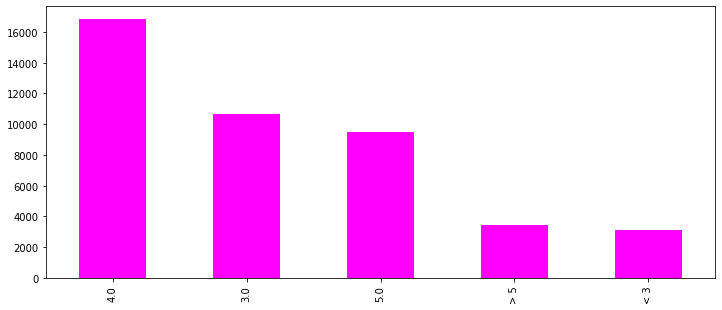

In [ ]:
sismosdf['Intensidad'].value_counts().plot(kind='bar', figsize=(12,5), grid=False, color='magenta')

In [ ]:
clases = ['< 3', '3', '4', '5', '> 5']
n_clases = len(clases)
print(clases)

['< 3', '3', '4', '5', '> 5']


In [ ]:
X = scaled_sismos
y = np.array(sismosdf['Label'])

In [ ]:
sns.pairplot(sismosdf[['MAGNITUDE',	'EPIDIST',	'CITY_LAT',	'CITY_LON','Intensidad']], hue = "Intensidad", height = 3, diag_kind='kde',palette='husl');
plt.show()

In [ ]:
sismosdf.drop(['Intensidad','MMI'], axis=1, inplace=True)

In [ ]:
sismosdf.head()

,MAGNITUDE,EPIDIST,CITY_LAT,CITY_LON,Label
79,4.0,47.0,33.22,-116.30,1
80,4.0,52.0,33.02,-116.84,1
81,4.0,84.0,32.77,-117.02,1
82,4.0,156.0,34.18,-118.17,1
85,6.0,28.0,39.80,-120.14,4
